In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
#jtplot.style()
jtplot.reset()

In [2]:
### lists and dicts to help clear dataframes
#list of columns i want to keep
const_cols = ["Province/State", "Country", "Country/Region", "Date last updated", "Last Update", "Confirmed", "Recovered", "Deaths"]
#dict of column names to change
column_names = {"Country": "Country/Region", "Date last updated": "Last Update"}
#dict of columns and values to put in NaNs
fillna_values = {'Province/State': "", "Country/Region": "", "Confirmed": 0, "Recovered": 0, "Deaths":0}

In [3]:
def read_time_series_csv(url):
    
    df_ts = pd.read_csv(url)
    
    #df_ts = df_ts.dropna(axis=0, how='all')
    #df_ts = df_ts.dropna(axis=1, how='all')

    df_text = df_ts[df_ts.columns[0:2]]
    df_text = df_text.fillna(value = '')
    
    df_val = df_ts[df_ts.columns[2:len(df_ts.columns)]]
    df_val = df_val.fillna(value = 0)
    
    df_ts = pd.concat([df_text,df_val],axis=1)

    return df_ts

In [4]:
def save_one_file(df_confirmed, df_deaths, df_recovered, file_name):
    with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
        df_confirmed.to_excel(writer, sheet_name='Confirmed')
        df_deaths.to_excel(writer, sheet_name='Deaths')
        df_recovered.to_excel(writer, sheet_name='Recovered')

In [5]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [6]:
df_confirmed = read_time_series_csv(url_confirmed)
df_deaths = read_time_series_csv(url_deaths)
df_recovered = read_time_series_csv(url_recovered)

In [7]:
save_one_file(df_confirmed, df_deaths, df_recovered, "TimeSeries.xlsx")

In [8]:
df_confirmed_groupby = df_confirmed.groupby('Country/Region').sum()
df_deaths_groupby = df_deaths.groupby('Country/Region').sum()
df_recovered_groupby = df_recovered.groupby('Country/Region').sum()

save_one_file(df_confirmed_groupby, df_deaths_groupby, df_recovered_groupby, "CasesByCountry.xlsx")

In [9]:
print("Shape of df_confirmed: {}".format(df_confirmed.shape))
print("Shape of df_deaths: {}".format(df_deaths.shape))
print("Shape of df_recovered: {}".format(df_recovered.shape))

#printing whole df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_confirmed)

Shape of df_confirmed: (173, 48)
Shape of df_deaths: (173, 48)
Shape of df_recovered: (173, 48)


In [10]:
china_confirmed = df_confirmed[df_confirmed['Country/Region']=="Mainland China"].iloc[:,4:].sum(axis=0)
china_deaths = df_deaths[df_deaths['Country/Region']=="Mainland China"].iloc[:,4:].sum(axis=0)
china_recovered = df_recovered[df_recovered['Country/Region']=="Mainland China"].iloc[:,4:].sum(axis=0)

print(china_confirmed)
#print(china_recovered_series)
#print(china_deaths_series)

1/22/20      547
1/23/20      639
1/24/20      916
1/25/20     1399
1/26/20     2062
1/27/20     2863
1/28/20     5494
1/29/20     6070
1/30/20     8124
1/31/20     9783
2/1/20     11871
2/2/20     16607
2/3/20     19693
2/4/20     23680
2/5/20     27409
2/6/20     30553
2/7/20     34075
2/8/20     36778
2/9/20     39790
2/10/20    42306
2/11/20    44327
2/12/20    44699
2/13/20    59832
2/14/20    66292
2/15/20    68347
2/16/20    70446
2/17/20    72364
2/18/20    74139
2/19/20    74546
2/20/20    74999
2/21/20    75472
2/22/20    76922
2/23/20    76938
2/24/20    77152
2/25/20    77660
2/26/20    78065
2/27/20    78498
2/28/20    78824
2/29/20    79251
3/1/20     79826
3/2/20     80026
3/3/20     80151
3/4/20     80271
3/5/20     80422
dtype: int64


In [11]:
dates_confirmed = china_confirmed.index.values
dates_deaths = china_deaths.index.values
dates_recovered = china_recovered.index.values

print(dates_confirmed)
#print(dates_1)
#print(dates_2)

dates_datetime_confirmed = pd.to_datetime(dates_confirmed, infer_datetime_format=True)
dates_datetime_deaths = pd.to_datetime(dates_deaths, infer_datetime_format=True)
dates_datetime_recovered = pd.to_datetime(dates_recovered, infer_datetime_format=True)

print(dates_datetime_confirmed)


['1/22/20' '1/23/20' '1/24/20' '1/25/20' '1/26/20' '1/27/20' '1/28/20'
 '1/29/20' '1/30/20' '1/31/20' '2/1/20' '2/2/20' '2/3/20' '2/4/20'
 '2/5/20' '2/6/20' '2/7/20' '2/8/20' '2/9/20' '2/10/20' '2/11/20'
 '2/12/20' '2/13/20' '2/14/20' '2/15/20' '2/16/20' '2/17/20' '2/18/20'
 '2/19/20' '2/20/20' '2/21/20' '2/22/20' '2/23/20' '2/24/20' '2/25/20'
 '2/26/20' '2/27/20' '2/28/20' '2/29/20' '3/1/20' '3/2/20' '3/3/20'
 '3/4/20' '3/5/20']
DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22'

In [12]:
#something for converting datetime for x axis
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

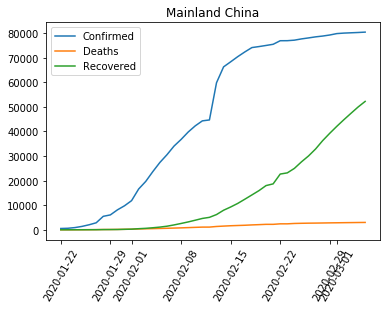

In [13]:
plt.plot(dates_datetime_confirmed, china_confirmed, dates_datetime_deaths, china_deaths, dates_datetime_recovered, china_recovered)
plt.xticks(rotation=60)
plt.legend(['Confirmed', 'Deaths', 'Recovered'])
plt.title("Mainland China")
plt.savefig("img/china.png",bbox_inches='tight')

In [14]:
countries_ts = df_confirmed['Country/Region'].unique()
print(len(countries_ts))
print(countries_ts)

90
['Mainland China' 'Thailand' 'Japan' 'South Korea' 'Taiwan' 'US' 'Macau'
 'Hong Kong' 'Singapore' 'Vietnam' 'France' 'Nepal' 'Malaysia' 'Canada'
 'Australia' 'Cambodia' 'Sri Lanka' 'Germany' 'Finland'
 'United Arab Emirates' 'Philippines' 'India' 'Italy' 'UK' 'Russia'
 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt' 'Iran' 'Lebanon' 'Iraq'
 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria' 'Croatia' 'Switzerland'
 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand'
 'Nigeria' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan'
 'Czech Republic' 'Armenia' 'Dominican Republic' 'Indonesia' 'Portugal'
 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile'
 'Jordan' 'Ukraine' 'Saint Barthelemy' 'Hungary' 'Faroe Islands'
 'Gibraltar' 'Liechtenstein' 'Poland' 'Tunisia' 'Palestine'
 'Bosnia and Herzegovina' 'Slovenia' '

In [15]:
#for country in countries_ts:
    #plt.plot(dates_datetime, ts_df_list[0][ts_df_list[0]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    #plt.show()

In [16]:
#math for using floor
import math

23


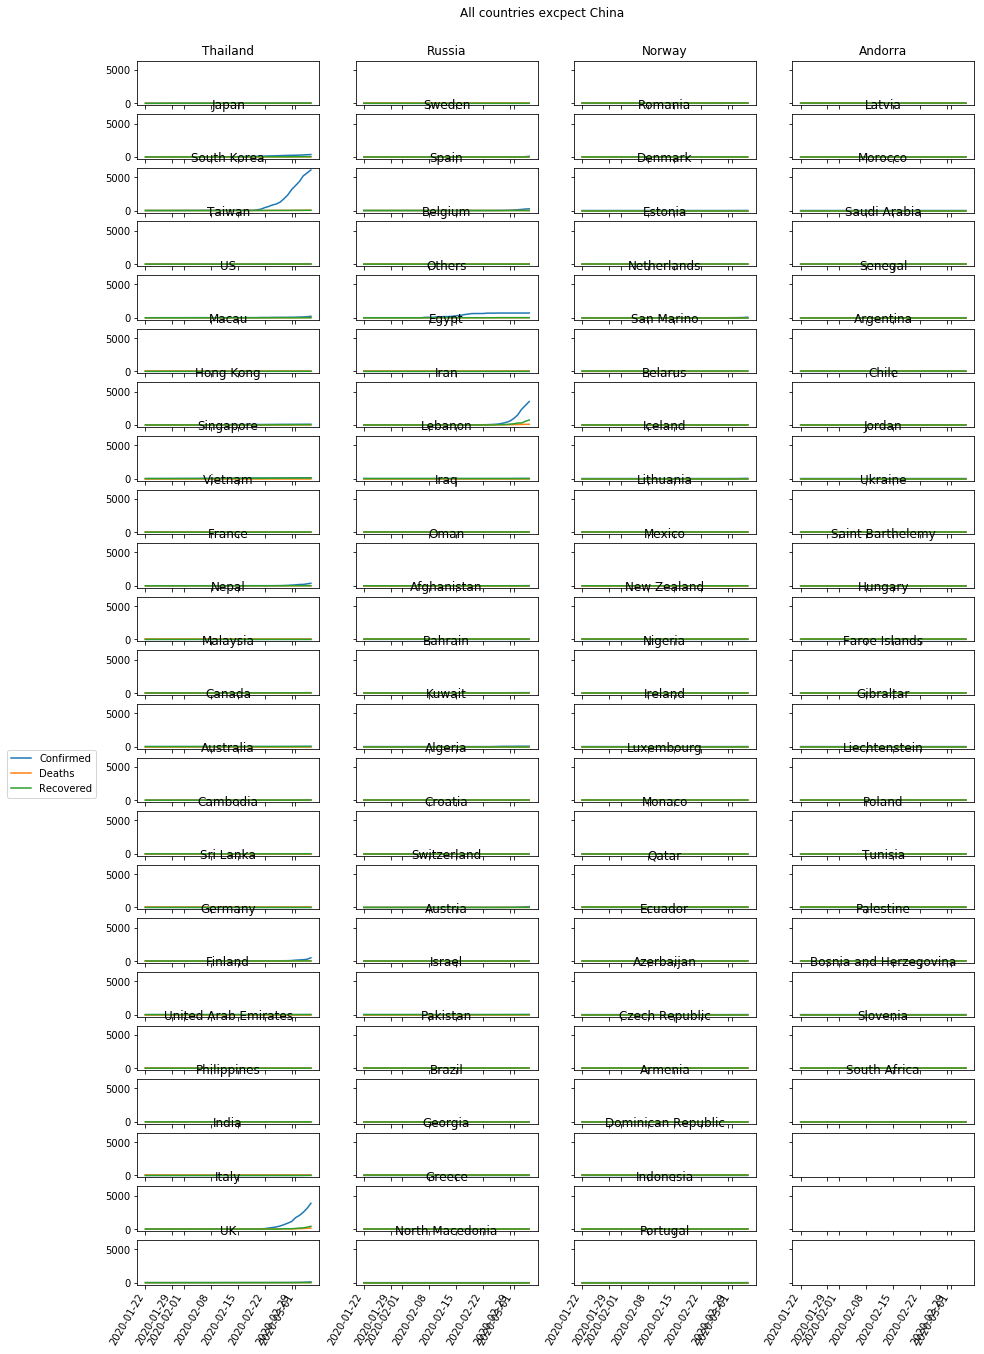

In [17]:
#country_confirmed = df_confirmed[df_confirmed['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
#dates_confirmed = country_confirmed.index.values
#dates_datetime_confirmed = pd.to_datetime(dates_confirmed, infer_datetime_format=True)

#country_deaths = df_deaths[df_deaths['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
#dates_deaths = country_deaths.index.values
#dates_datetime_deaths = pd.to_datetime(dates_deaths, infer_datetime_format=True)

#country_recovered = df_recovered[df_recovered['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
#dates_recovered = country_recovered.index.values
#dates_datetime_recovered = pd.to_datetime(dates_recovered, infer_datetime_format=True)
    
plots_in_row = 4
#define how many rows on how many countries in list without china
plots_in_col = math.ceil((len(countries_ts)-1)/plots_in_row)

print(plots_in_col)

fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, 25), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_ts[1:]:
    
    axs[i][j].plot(dates_datetime_confirmed,df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_deaths,df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_recovered,df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('All countries excpect China',y=0.91)
fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0., 0., 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
#plt.savefig("img/rest.png",bbox_inches='tight')

In [18]:
#list of number of confirmed cases from last column
confirmed_country = []
row = len(dates_confirmed)-1
for country in countries_ts:
    confirmed_country.append(df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0)[row])

ccc = confirmed_country.copy()
ccc.sort()
print(ccc)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 8, 8, 10, 10, 10, 12, 12, 12, 13, 16, 16, 16, 16, 21, 29, 30, 31, 34, 35, 37, 41, 44, 47, 50, 50, 55, 55, 58, 82, 87, 94, 105, 114, 115, 117, 221, 259, 360, 377, 482, 706, 3513, 3858, 6088, 80422]


In [19]:
limit_high = 250
limit_low = 50

In [20]:
dictionary = {"Country":countries_ts ,"Confirmed":confirmed_country}

countries_last_date = pd.DataFrame(dictionary)
# print(countries_last_date)

if_over_high_limit = countries_last_date.apply(lambda x: True if x['Confirmed'] > limit_high else False , axis=1)

numOfRows = len(if_over_high_limit[if_over_high_limit == True].index)
 
print('Number of countries with over {} confirmed cases: {}'.format(limit_high,numOfRows))

Number of countries with over 250 confirmed cases: 9


In [21]:
#
indexTrue = if_over_high_limit[ if_over_high_limit == False ].index
indexFalse = if_over_high_limit[ if_over_high_limit == True ].index
print(indexTrue)
print(indexFalse)

#copying to not change original df
countries_over_limit = countries_last_date.copy()
countries_under_limit = countries_last_date.copy()

countries_over_limit.drop(indexTrue, inplace=True, axis=0)
countries_under_limit.drop(indexFalse, inplace=True, axis=0)

#print(countries_over_limit)
#print(countries_under_limit)

Int64Index([ 1,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21,
            23, 24, 25, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
            43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
            77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
           dtype='int64')
Int64Index([0, 2, 3, 10, 17, 22, 26, 28, 30], dtype='int64')


In [22]:
#print(countries_last_date)

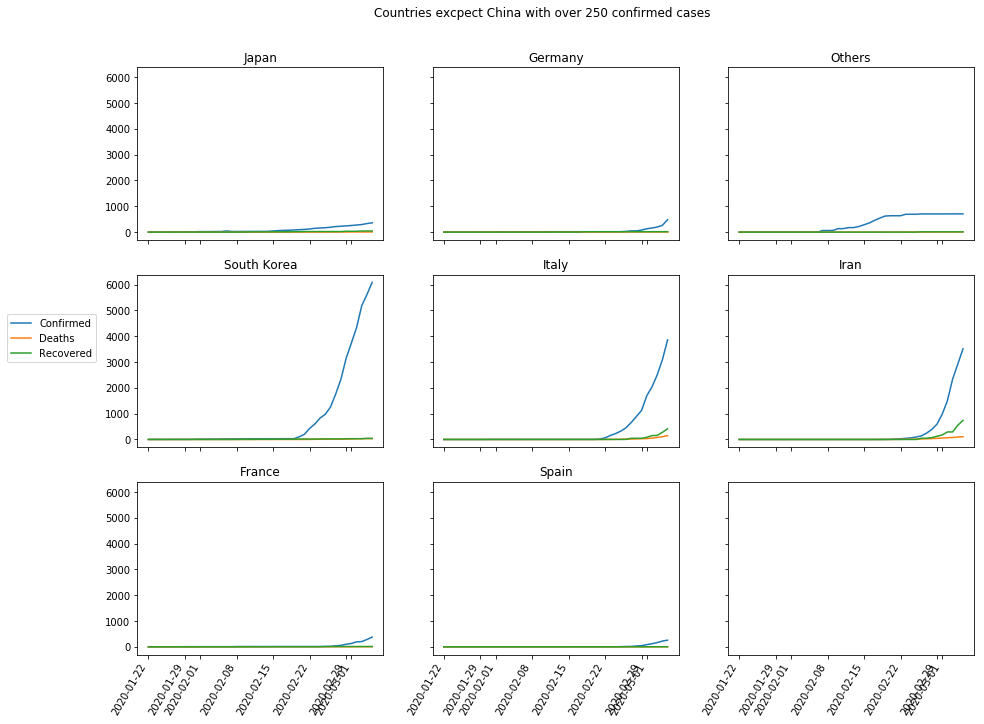

In [23]:
###plot for countries with confirmed cases over limit
plots_in_row = 3
#define how many rows on how many countries in list without china
plots_in_col = math.ceil((numOfRows-1)/plots_in_row)

fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_over_limit["Country"][1:]:
    #print(country)
    axs[i][j].plot(dates_datetime_confirmed, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_deaths, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_recovered, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('Countries excpect China with over {} confirmed cases'.format(limit_high),y=0.95)
fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0., 0.1, 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest_over_high_limit.png",bbox_inches='tight')

In [24]:
dictionary = {"Country":countries_ts ,"Confirmed":confirmed_country}

countries_last_date = pd.DataFrame(dictionary)
# print(countries_last_date)

if_over_low_limit = countries_last_date.apply(lambda x: True if x['Confirmed'] > limit_low and x['Confirmed'] < limit_high else False , axis=1)

numOfRows = len(if_over_low_limit[if_over_low_limit == True].index)

print('Number of countries with over {} confirmed cases: {}'.format(limit_low,numOfRows))

Number of countries with over 50 confirmed cases: 11


In [25]:
#
indexTrue = if_over_low_limit[ if_over_low_limit == False ].index
indexFalse = if_over_low_limit[ if_over_low_limit == True ].index
print(indexTrue)
print(indexFalse)

#copying to not change original df
countries_over_limit = countries_last_date.copy()
countries_under_limit = countries_last_date.copy()

countries_over_limit.drop(indexTrue, inplace=True, axis=0)
countries_under_limit.drop(indexFalse, inplace=True, axis=0)

#print(countries_over_limit)
#print(countries_under_limit)

Int64Index([ 0,  1,  2,  3,  4,  6,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
            21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 40, 41, 42,
            43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
            62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
            79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
           dtype='int64')
Int64Index([5, 7, 8, 14, 23, 25, 35, 36, 39, 47, 51], dtype='int64')


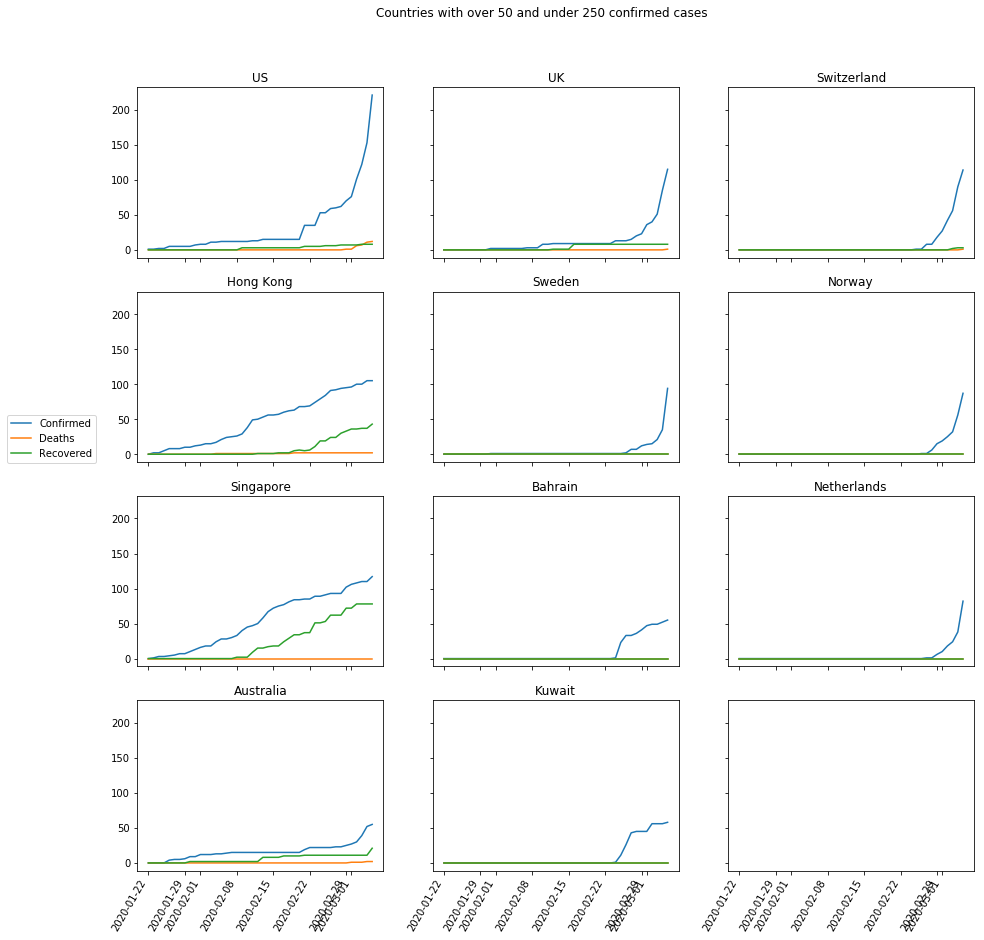

In [26]:
plots_in_row = 3
#define how many rows on how many countries in list without china
plots_in_col = math.ceil((numOfRows)/plots_in_row)

fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_over_limit["Country"][:]:
    #print(country)
    axs[i][j].plot(dates_datetime_confirmed, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_deaths, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_recovered, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('Countries with over {} and under {} confirmed cases'.format(limit_low, limit_high),y=0.95)
fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0., 0.1, 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest_over_low_limit.png",bbox_inches='tight')

In [27]:
dictionary = {"Country":countries_ts ,"Confirmed":confirmed_country}

countries_last_date = pd.DataFrame(dictionary)
# print(countries_last_date)

if_under_low_limit = countries_last_date.apply(lambda x: True if x['Confirmed'] < limit_low else False , axis=1)

numOfRows = len(if_under_low_limit[if_under_low_limit == True].index)

print('Number of countries with under {} confirmed cases: {}'.format(limit_low,numOfRows))

Number of countries with under 50 confirmed cases: 68


In [28]:
#
indexTrue = if_under_low_limit[ if_under_low_limit == False ].index
indexFalse = if_under_low_limit[ if_under_low_limit == True ].index
print(indexTrue)
print(indexFalse)

#copying to not change original df
countries_over_limit = countries_last_date.copy()
countries_under_limit = countries_last_date.copy()

countries_over_limit.drop(indexTrue, inplace=True, axis=0)
countries_under_limit.drop(indexFalse, inplace=True, axis=0)

#print(countries_over_limit)
#print(countries_under_limit)

Int64Index([ 0,  2,  3,  5,  7,  8, 10, 12, 14, 17, 22, 23, 25, 26, 27, 28, 30,
            35, 36, 39, 47, 51],
           dtype='int64')
Int64Index([ 1,  4,  6,  9, 11, 13, 15, 16, 18, 19, 20, 21, 24, 29, 31, 32, 33,
            34, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55,
            56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
            73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
            89],
           dtype='int64')


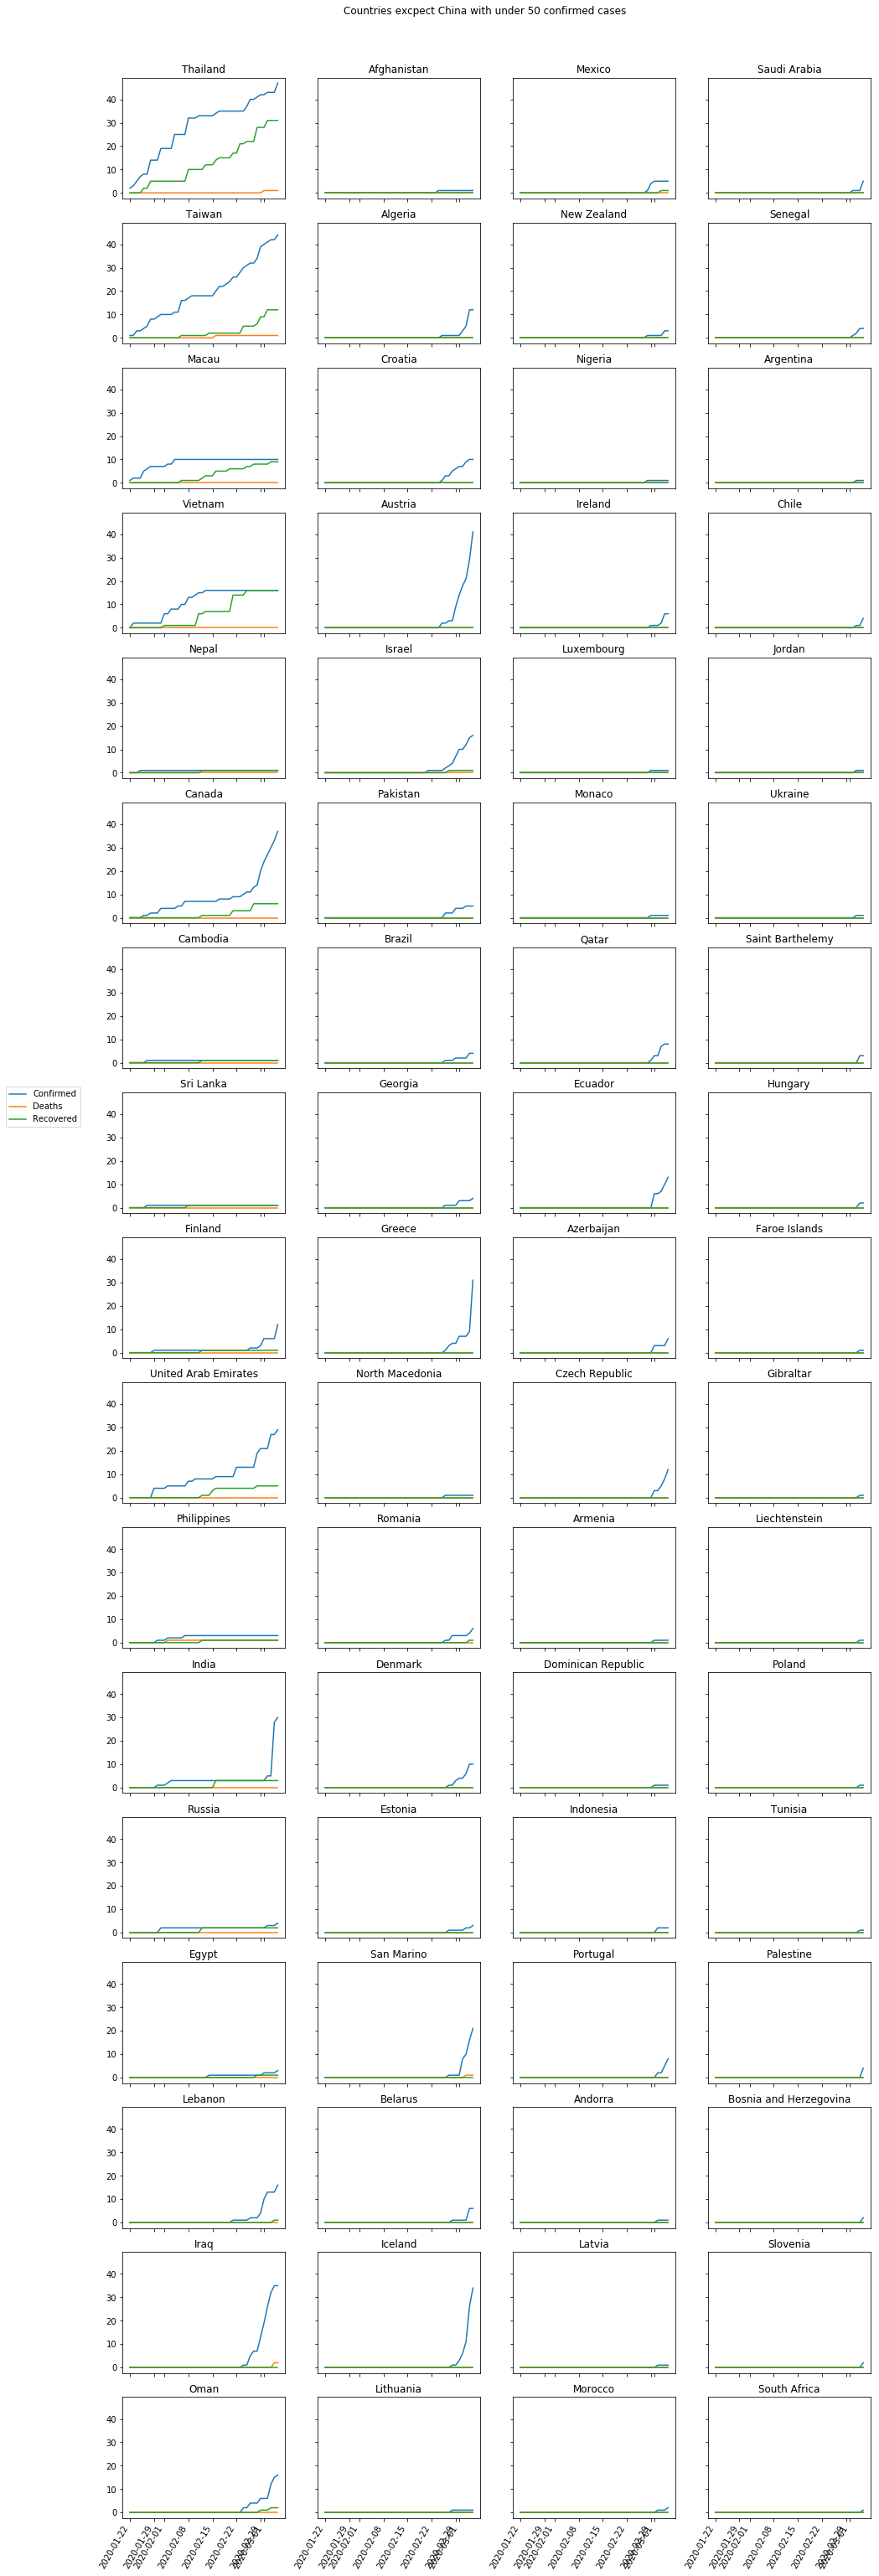

In [29]:
###plot for countries with confirmed cases over limit
plots_in_row = 4
#define how many rows on how many countries in list without china
plots_in_col = math.ceil((numOfRows)/plots_in_row)
#print(plots_in_col)
fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(16, plots_in_col*3.5), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_over_limit["Country"]:
    #print(country)
    axs[i][j].plot(dates_datetime_confirmed, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_deaths, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_recovered, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('Countries excpect China with under {} confirmed cases'.format(limit_low),y=0.90)
fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0., 0.1, 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest_under_low_limit.png",bbox_inches='tight')

In [30]:
#df_confirmed

In [31]:
def make_df_colCountry_rowValues(df, countries_ts):
    #new df - columns will be countries, index is date
    df_colCountry_rowConfirmed = pd.DataFrame()
    #print(df_colCountry_rowConfirmed)
    for i, country in enumerate(countries_ts,0):
        column = df[df['Country/Region']==country].iloc[:,4:].sum(axis=0)
        df_colCountry_rowConfirmed.insert(i, country, column)
    print(df_colCountry_rowConfirmed.tail(3))
    return df_colCountry_rowConfirmed

In [32]:
df_colCountry_rowConfirmed = make_df_colCountry_rowValues(df_confirmed, countries_ts)
df_colCountry_rowDeaths = make_df_colCountry_rowValues(df_deaths, countries_ts)
df_colCountry_rowRecovered = make_df_colCountry_rowValues(df_recovered, countries_ts)

        Mainland China  Thailand  Japan  South Korea  Taiwan   US  Macau  \
3/3/20           80151        43    293         5186      42  122     10   
3/4/20           80271        43    331         5621      42  153     10   
3/5/20           80422        47    360         6088      44  221     10   

        Hong Kong  Singapore  Vietnam  ...  Hungary  Faroe Islands  Gibraltar  \
3/3/20        100        110       16  ...        0              0          0   
3/4/20        105        110       16  ...        2              1          1   
3/5/20        105        117       16  ...        2              1          1   

        Liechtenstein  Poland  Tunisia  Palestine  Bosnia and Herzegovina  \
3/3/20              0       0        0          0                       0   
3/4/20              1       1        1          0                       0   
3/5/20              1       1        1          4                       2   

        Slovenia  South Africa  
3/3/20         0            

In [33]:
#przyrosty względne
rel_change_confirmed = df_colCountry_rowConfirmed.pct_change()

In [34]:
abs_change_confirmed = df_colCountry_rowConfirmed.diff()
abs_change_deaths = df_colCountry_rowDeaths.diff()
abs_change_recovered = df_colCountry_rowRecovered.diff()
print(abs_change_confirmed.tail(3))

        Mainland China  Thailand  Japan  South Korea  Taiwan    US  Macau  \
3/3/20           125.0       0.0   19.0        851.0     1.0  21.0    0.0   
3/4/20           120.0       0.0   38.0        435.0     0.0  31.0    0.0   
3/5/20           151.0       4.0   29.0        467.0     2.0  68.0    0.0   

        Hong Kong  Singapore  Vietnam  ...  Hungary  Faroe Islands  Gibraltar  \
3/3/20        0.0        2.0      0.0  ...      0.0            0.0        0.0   
3/4/20        5.0        0.0      0.0  ...      2.0            1.0        1.0   
3/5/20        0.0        7.0      0.0  ...      0.0            0.0        0.0   

        Liechtenstein  Poland  Tunisia  Palestine  Bosnia and Herzegovina  \
3/3/20            0.0     0.0      0.0        0.0                     0.0   
3/4/20            1.0     1.0      1.0        0.0                     0.0   
3/5/20            0.0     0.0      0.0        4.0                     2.0   

        Slovenia  South Africa  
3/3/20       0.0        

In [35]:
#plt.plot(df_colCountry_rowConfirmed["Mainland China"].diff())

In [36]:
daily_abs_change_confirmed_all = abs_change_confirmed.sum(axis=1)
daily_abs_change_deaths_all = abs_change_deaths.sum(axis=1)
daily_abs_change_recovered_all = abs_change_recovered.sum(axis=1)

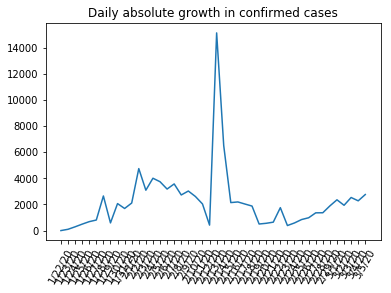

In [37]:
plt.plot(dates_confirmed, daily_abs_change_confirmed_all)
plt.xticks(rotation=60)
#plt.legend(['Absolute growth in confirmed cases'])
plt.title("Daily absolute growth in confirmed cases")
plt.savefig("img/abs_growth_confirmed.png",bbox_inches='tight')

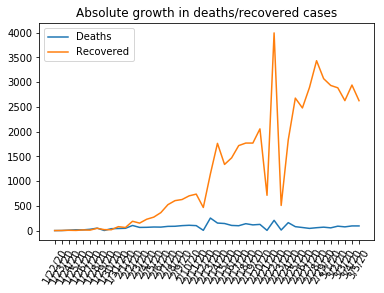

In [38]:
plt.plot(dates_confirmed, daily_abs_change_deaths_all, dates_confirmed,daily_abs_change_recovered_all)
plt.xticks(rotation=60)
plt.legend(['Deaths', 'Recovered'])
plt.title("Absolute growth in deaths/recovered cases")
plt.savefig("img/abs_growth_deaths_recovered.png",bbox_inches='tight')